**Installing Requirements**

In [1]:
!pip install d3rlpy

In [2]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gym

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score, classification_report, roc_curve, auc

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from d3rlpy.algos import CQL
from d3rlpy.datasets import MDPDataset

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


**Load dataset (focused columns) & initial filtering — Task 1**

In [3]:
DATA_PATH = "/content/accepted_2007_to_2018Q4.csv"
SAMPLE_FRAC = 0.25
USECOLS = [
    'loan_amnt', 'term', 'int_rate', 'grade', 'sub_grade',
    'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
    'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'revol_util',
    'total_acc', 'open_acc', 'pub_rec', 'loan_status'
]

print("Reading CSV")
df = pd.read_csv(DATA_PATH, usecols=USECOLS, low_memory=False)
print("Original rows:", len(df))
if SAMPLE_FRAC < 1.0:
    df = df.sample(frac=SAMPLE_FRAC, random_state=SEED).reset_index(drop=True)
    print("After sampling rows:", len(df))

good_status = ['Fully Paid', 'Charged Off']
df = df[df['loan_status'].isin(good_status)].copy()
print("After status filtering (Fully Paid / Charged Off):", len(df))

display(df.head())
display(df['loan_status'].value_counts())


Reading CSV
Original rows: 211931
After sampling rows: 52983
After status filtering (Fully Paid / Charged Off): 46739


,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,open_acc,pub_rec,revol_util,total_acc
2,12000.0,36 months,15.41,D,D1,1 year,RENT,45000.0,Source Verified,Fully Paid,credit_card,FL,13.68,0.0,8.0,0.0,69.3,21.0
4,19200.0,36 months,9.17,B,B2,10+ years,MORTGAGE,113000.0,Source Verified,Fully Paid,major_purchase,AZ,21.59,0.0,16.0,0.0,66.9,44.0
5,10000.0,36 months,9.99,B,B3,8 years,OWN,40000.0,Not Verified,Fully Paid,debt_consolidation,AL,27.27,0.0,10.0,0.0,33.3,32.0
6,15000.0,60 months,21.99,F,F1,10+ years,MORTGAGE,50000.0,Verified,Charged Off,debt_consolidation,KS,19.43,2.0,8.0,0.0,90.7,25.0
7,25000.0,60 months,13.67,C,C4,8 years,MORTGAGE,100000.0,Not Verified,Fully Paid,debt_consolidation,CA,16.45,0.0,11.0,0.0,53.3,18.0


,count
loan_status,
Fully Paid,37485
Charged Off,9254


**Target creation & simple EDA**

                       count unique                 top   freq          mean  \
loan_amnt            46739.0    NaN                 NaN    NaN  14578.272963   
term                   46739      2           36 months  35682           NaN   
int_rate             46739.0    NaN                 NaN    NaN     12.155685   
grade                  46739      7                   B  14274           NaN   
sub_grade              46739     35                  B3   2946           NaN   
emp_length             43733     11           10+ years  15424           NaN   
home_ownership         46739      4            MORTGAGE  22853           NaN   
annual_inc           46739.0    NaN                 NaN    NaN  77438.328553   
verification_status    46739      3     Source Verified  19982           NaN   
loan_status            46739      2          Fully Paid  37485           NaN   
purpose                46739     12  debt_consolidation  26819           NaN   
addr_state             46739     49     

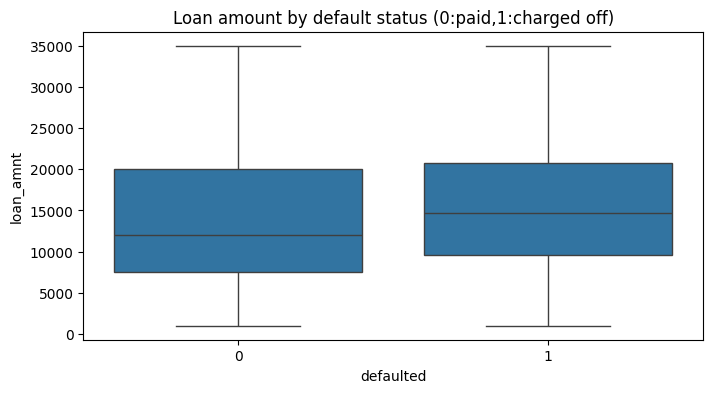

Overall default rate: 0.1979931106784484


In [4]:
df['defaulted'] = (df['loan_status'] == 'Charged Off').astype(int)

print(df.describe(include='all').T)

missing = df.isna().mean().sort_values(ascending=False)
print("Missing fraction per column:\n", missing)

plt.figure(figsize=(8,4))
sns.boxplot(x='defaulted', y='loan_amnt', data=df)
plt.title("Loan amount by default status (0:paid,1:charged off)")
plt.show()

print("Overall default rate:", df['defaulted'].mean())

**Feature cleaning helpers**

In [5]:
def parse_term(x):
    if pd.isna(x): return np.nan
    return int(x.split()[0])

def parse_percent_str(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str) and '%' in x:
        return float(x.strip().replace('%',''))/100.0
    try:
        return float(x)
    except:
        return np.nan

import re
def parse_emp_length(x):
    if pd.isna(x): return np.nan
    if x.strip() == 'n/a':
        return np.nan
    if '10+' in x:
        return 10
    if '< 1' in x:
        return 0
    m = re.search(r'(\d+)', x)
    return int(m.group(1)) if m else np.nan

df['term'] = df['term'].apply(parse_term)
df['int_rate'] = df['int_rate'].apply(parse_percent_str)
df['revol_util'] = df['revol_util'].apply(parse_percent_str)
df['emp_length'] = df['emp_length'].apply(parse_emp_length)


**Feature selection & preprocessing pipeline**

In [6]:
NUMERIC_COLS = ['loan_amnt','int_rate','annual_inc','dti','revol_util',
                'total_acc','open_acc','pub_rec','delinq_2yrs','emp_length']
CAT_COLS = ['term','grade','sub_grade','home_ownership','verification_status','purpose','addr_state']

for c in NUMERIC_COLS + CAT_COLS:
    if c not in df.columns:
        print("Warning: column missing:", c)

X_df = df[NUMERIC_COLS + CAT_COLS].copy()
y = df['defaulted'].values
loan_amnt = df['loan_amnt'].values
int_rate_decimal = df['int_rate'].values

numeric_transformer = Pipeline = None
from sklearn.pipeline import Pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, NUMERIC_COLS),
    ('cat', categorical_transformer, CAT_COLS)
], remainder='drop')

X_train_df, X_test_df, y_train, y_test, loanamnt_train, loanamnt_test, int_rate_train, int_rate_test = \
    train_test_split(X_df, y, loan_amnt, int_rate_decimal, test_size=0.20, stratify=y, random_state=SEED)

X_train_df, X_val_df, y_train, y_val, loanamnt_train, loanamnt_val, int_rate_train, int_rate_val = \
    train_test_split(X_train_df, y_train, loanamnt_train, int_rate_train, test_size=0.2, stratify=y_train, random_state=SEED)

print("Train / Val / Test sizes:", len(X_train_df), len(X_val_df), len(X_test_df))

preprocessor.fit(X_train_df)

X_train = preprocessor.transform(X_train_df)
X_val = preprocessor.transform(X_val_df)
X_test = preprocessor.transform(X_test_df)

print("Feature matrix shape (train):", X_train.shape)

Train / Val / Test sizes: 29912 7479 9348
Feature matrix shape (train): (29912, 122)


**Supervised deep learning model (MLP) — training & evaluation**

In [7]:
def make_loader(X, y, batch_size=256, shuffle=True):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y.reshape(-1,1), dtype=torch.float32)
    ds = TensorDataset(X_t, y_t)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train, batch_size=512, shuffle=True)
val_loader = make_loader(X_val, y_val, batch_size=1024, shuffle=False)

class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128,64,32], dropout=0.2):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

input_dim = X_train.shape[1]
model = MLPClassifier(input_dim, hidden_dims=[256,128,64], dropout=0.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Using device:", device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

EPOCHS = 20
best_val_auc = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device); yb = yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb.squeeze(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_train_loss = total_loss / len(train_loader.dataset)

    model.eval()
    all_logits = []
    all_y = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            logits = model(xb)
            all_logits.append(logits.cpu().numpy())
            all_y.append(yb.numpy())
    all_logits = np.concatenate(all_logits)
    all_y = np.concatenate(all_y).reshape(-1)
    probs = 1.0 / (1.0 + np.exp(-all_logits))
    val_auc = roc_auc_score(all_y, probs)
    # F1 at 0.5 threshold
    preds = (probs >= 0.5).astype(int)
    val_f1 = f1_score(all_y, preds)

    print(f"Epoch {epoch}/{EPOCHS}: train_loss={avg_train_loss:.4f}, val_auc={val_auc:.4f}, val_f1={val_f1:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), "best_mlp.pt")


Using device: cuda
Epoch 1/20: train_loss=0.4826, val_auc=0.7259, val_f1=0.0000
Epoch 2/20: train_loss=0.4410, val_auc=0.7270, val_f1=0.0000
Epoch 3/20: train_loss=0.4386, val_auc=0.7267, val_f1=0.0000
Epoch 4/20: train_loss=0.4356, val_auc=0.7265, val_f1=0.2470
Epoch 5/20: train_loss=0.4329, val_auc=0.7241, val_f1=0.2330
Epoch 6/20: train_loss=0.4311, val_auc=0.7231, val_f1=0.2540
Epoch 7/20: train_loss=0.4281, val_auc=0.7236, val_f1=0.2112
Epoch 8/20: train_loss=0.4231, val_auc=0.7195, val_f1=0.2957
Epoch 9/20: train_loss=0.4216, val_auc=0.7153, val_f1=0.2732
Epoch 10/20: train_loss=0.4177, val_auc=0.7133, val_f1=0.2654
Epoch 11/20: train_loss=0.4135, val_auc=0.7106, val_f1=0.2882
Epoch 12/20: train_loss=0.4076, val_auc=0.7056, val_f1=0.2946
Epoch 13/20: train_loss=0.4021, val_auc=0.7027, val_f1=0.2800
Epoch 14/20: train_loss=0.4008, val_auc=0.7008, val_f1=0.2846
Epoch 15/20: train_loss=0.3942, val_auc=0.6939, val_f1=0.2590
Epoch 16/20: train_loss=0.3905, val_auc=0.6957, val_f1=0.266

In [8]:
model.load_state_dict(torch.load("best_mlp.pt"))
model.eval()

test_loader = make_loader(X_test, y_test, batch_size=2048, shuffle=False)
all_logits = []
all_y = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        all_logits.append(logits.cpu().numpy())
        all_y.append(yb.numpy())
all_logits = np.concatenate(all_logits)
all_y = np.concatenate(all_y).reshape(-1)
probs_test = 1.0 / (1.0 + np.exp(-all_logits))
preds_test = (probs_test >= 0.5).astype(int)

test_auc = roc_auc_score(all_y, probs_test)
test_f1 = f1_score(all_y, preds_test)
print("Supervised MLP Test AUC:", test_auc)
print("Supervised MLP Test F1 (0.5 threshold):", test_f1)
print(classification_report(all_y, preds_test, digits=4, zero_division=1))


Supervised MLP Test AUC: 0.7400334165721034
Supervised MLP Test F1 (0.5 threshold): 0.0
              precision    recall  f1-score   support

         0.0     0.8020    1.0000    0.8901      7497
         1.0     1.0000    0.0000    0.0000      1851

    accuracy                         0.8020      9348
   macro avg     0.9010    0.5000    0.4451      9348
weighted avg     0.8412    0.8020    0.7139      9348



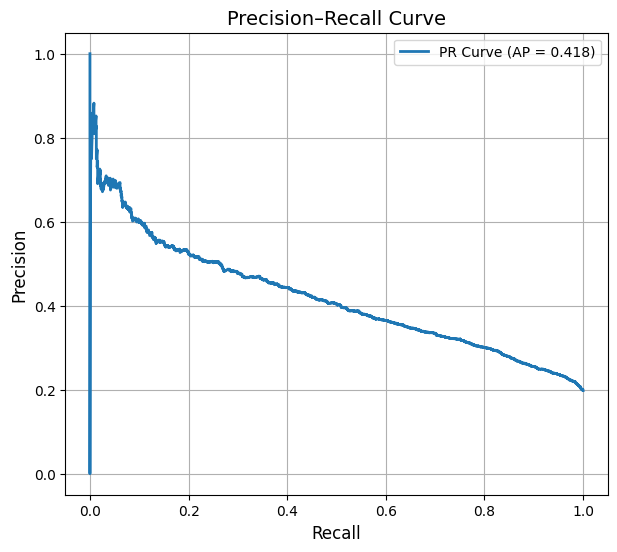

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(all_y, probs_test)
ap_score = average_precision_score(all_y, probs_test)

plt.figure(figsize=(7, 6))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.3f})', linewidth=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision–Recall Curve', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


**Task 3: Offline RL agent (state/action/reward) + training (CQL)**

In [10]:
def compute_rewards(loan_amounts, int_rates, defaults):
    rewards = np.where(defaults == 0, loan_amounts * int_rates, -loan_amounts)
    return rewards.astype(np.float32)

rewards_train = compute_rewards(loanamnt_train, int_rate_train, y_train)
rewards_val = compute_rewards(loanamnt_val, int_rate_val, y_val)
rewards_test = compute_rewards(loanamnt_test, int_rate_test, y_test)

print("Example rewards (train):", rewards_train[:6])


Example rewards (train): [ 76552. -10000.  -6000.  62010. 235212.  85120.]


**Create MDP Dataset for d3rlpy**

In [11]:
def make_offline_dataset(X_array, rewards_array):
    n = X_array.shape[0]

    obs_approve = X_array.astype(np.float32)
    acts_approve = np.ones((n,), dtype=np.int32)
    rewards_approve = rewards_array.astype(np.float32)
    terms_approve = np.ones((n,), dtype=bool)

    obs_deny = X_array.astype(np.float32)
    acts_deny = np.zeros((n,), dtype=np.int32)
    rewards_deny = np.zeros((n,), dtype=np.float32)
    terms_deny = np.ones((n,), dtype=bool)

    obs = np.vstack([obs_approve, obs_deny])
    acts = np.concatenate([acts_approve, acts_deny])
    rewards = np.concatenate([rewards_approve, rewards_deny])
    terms = np.concatenate([terms_approve, terms_deny])
    return obs, acts, rewards, terms

obs_train, acts_train, rew_train, terms_train = make_offline_dataset(X_train, rewards_train)
obs_val, acts_val, rew_val, terms_val = make_offline_dataset(X_val, rewards_val)
obs_test, acts_test, rew_test, terms_test = make_offline_dataset(X_test, rewards_test)

print("Offline dataset sizes (train obs):", obs_train.shape, acts_train.shape, rew_train.shape)


Offline dataset sizes (train obs): (59824, 122) (59824,) (59824,)


In [12]:
obs_rl = np.vstack([obs_train, obs_val])
acts_rl = np.concatenate([acts_train, acts_val])
rews_rl = np.concatenate([rew_train, rew_val])
terms_rl = np.concatenate([terms_train, terms_val])

mdp_dataset = MDPDataset(observations=obs_rl, actions=acts_rl, rewards=rews_rl, terminals=terms_rl)
print("MDPDataset created. Num transitions:", len(obs_rl))


2025-10-30 10:43.48 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(122,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-10-30 10:43.48 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2025-10-30 10:43.48 [info     ] Action size has been automatically determined. action_size=2
MDPDataset created. Num transitions: 74782


**Train a CQL (Conservative Q Learning) agent**

In [13]:
from d3rlpy.algos import DiscreteCQLConfig
from d3rlpy.models.encoders import VectorEncoderFactory
import torch

cql_config = DiscreteCQLConfig(
    learning_rate=1e-3,
    batch_size=256,
    encoder_factory=VectorEncoderFactory(hidden_units=[256, 256]),
)

device = "cuda" if torch.cuda.is_available() else "cpu"
cql = cql_config.create(device=device)

cql.fit(
    mdp_dataset,
    n_steps=100000,
)

cql.save_model("discrete_cql_model")


2025-10-30 10:43.51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(122,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-10-30 10:43.51 [debug    ] Building models...            
2025-10-30 10:43.51 [debug    ] Models have been built.       
2025-10-30 10:43.51 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20251030104351
2025-10-30 10:43.51 [info     ] Parameters                     params={'observation_shape': [122], 'action_size': 2, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'learning_rate': 0.001, 'optim_factory': {'type': 'ada

Epoch 1/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 10:45.38 [info     ] DiscreteCQL_20251030104351: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.005229984641075134, 'time_algorithm_update': 0.005240232896804809, 'loss': 68672.50468632813, 'td_loss': 68671.27668242187, 'conservative_loss': 1.228006725436449, 'time_step': 0.010659440970420837} step=10000
2025-10-30 10:45.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030104351/model_10000.d3


Epoch 2/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 10:47.26 [info     ] DiscreteCQL_20251030104351: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.005257087659835815, 'time_algorithm_update': 0.005195548939704895, 'loss': 68728.58927929688, 'td_loss': 68726.7814828125, 'conservative_loss': 1.8077958030104637, 'time_step': 0.010644542288780213} step=20000
2025-10-30 10:47.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030104351/model_20000.d3


Epoch 3/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 10:49.14 [info     ] DiscreteCQL_20251030104351: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.005320193243026733, 'time_algorithm_update': 0.005259715414047241, 'loss': 68636.82450273438, 'td_loss': 68634.37982773437, 'conservative_loss': 2.444654131066799, 'time_step': 0.010777083468437195} step=30000
2025-10-30 10:49.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030104351/model_30000.d3


Epoch 4/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 10:51.02 [info     ] DiscreteCQL_20251030104351: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.005279988193511963, 'time_algorithm_update': 0.005232949042320251, 'loss': 68690.83681679687, 'td_loss': 68687.81306289062, 'conservative_loss': 3.0237637568712232, 'time_step': 0.010705345201492309} step=40000
2025-10-30 10:51.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030104351/model_40000.d3


Epoch 5/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 10:52.50 [info     ] DiscreteCQL_20251030104351: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.005272436642646789, 'time_algorithm_update': 0.005227987265586853, 'loss': 68621.48735507812, 'td_loss': 68618.08247851563, 'conservative_loss': 3.404901023030281, 'time_step': 0.010694129276275634} step=50000
2025-10-30 10:52.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030104351/model_50000.d3


Epoch 6/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 10:54.38 [info     ] DiscreteCQL_20251030104351: epoch=6 step=60000 epoch=6 metrics={'time_sample_batch': 0.005274467611312866, 'time_algorithm_update': 0.005226233243942261, 'loss': 68533.173584375, 'td_loss': 68529.21062578126, 'conservative_loss': 3.9629903886318205, 'time_step': 0.010693271565437317} step=60000
2025-10-30 10:54.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030104351/model_60000.d3


Epoch 7/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 10:56.27 [info     ] DiscreteCQL_20251030104351: epoch=7 step=70000 epoch=7 metrics={'time_sample_batch': 0.005335499048233033, 'time_algorithm_update': 0.005296238040924072, 'loss': 68831.80999609375, 'td_loss': 68827.33112421875, 'conservative_loss': 4.478876984643936, 'time_step': 0.010830447459220887} step=70000
2025-10-30 10:56.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030104351/model_70000.d3


Epoch 8/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 10:58.16 [info     ] DiscreteCQL_20251030104351: epoch=8 step=80000 epoch=8 metrics={'time_sample_batch': 0.005340994429588318, 'time_algorithm_update': 0.0053207638025283815, 'loss': 68783.87280703125, 'td_loss': 68779.094115625, 'conservative_loss': 4.778688784527779, 'time_step': 0.010862244367599487} step=80000
2025-10-30 10:58.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030104351/model_80000.d3


Epoch 9/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 11:00.06 [info     ] DiscreteCQL_20251030104351: epoch=9 step=90000 epoch=9 metrics={'time_sample_batch': 0.005338958644866943, 'time_algorithm_update': 0.005324035024642944, 'loss': 68685.91694960938, 'td_loss': 68680.835059375, 'conservative_loss': 5.081853856134415, 'time_step': 0.010862018990516663} step=90000
2025-10-30 11:00.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030104351/model_90000.d3


Epoch 10/10:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-10-30 11:01.56 [info     ] DiscreteCQL_20251030104351: epoch=10 step=100000 epoch=10 metrics={'time_sample_batch': 0.00539248571395874, 'time_algorithm_update': 0.005356010484695434, 'loss': 68818.24240429688, 'td_loss': 68812.82610507813, 'conservative_loss': 5.416306467700005, 'time_step': 0.010951729726791383} step=100000
2025-10-30 11:01.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20251030104351/model_100000.d3


**Task 4: Evaluation & Comparison**

In [16]:
rl_actions = cql.predict(X_test.astype(np.float32))
rl_actions = np.array(rl_actions).astype(int)

est_rewards_rl = np.where(rl_actions == 1, rewards_test, 0.0)
estimated_value_rl = est_rewards_rl.mean()
print(f"RL policy estimated average reward per loan (test): {estimated_value_rl:.4f}")
print(f"Total expected profit on test (sum): {est_rewards_rl.sum():.2f} over {len(est_rewards_rl)} loans")


RL policy estimated average reward per loan (test): 108758.4766
Total expected profit on test (sum): 1016674240.00 over 9348 loans


In [17]:
model.eval()
with torch.no_grad():
    val_logits = model(torch.tensor(X_val, dtype=torch.float32).to(device)).cpu().numpy()
val_probs = 1.0/(1.0+np.exp(-val_logits))

thresholds = np.linspace(0.0, 1.0, 101)
best_tau = None
best_value = -1e12
for tau in thresholds:
    actions = (val_probs < tau).astype(int)
    est_rewards = np.where(actions == 1, rewards_val, 0.0)
    val = est_rewards.mean()
    if val > best_value:
        best_value = val
        best_tau = tau

print("Best validation threshold (max expected reward):", best_tau, "value:", best_value)

with torch.no_grad():
    test_logits = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy()
test_probs = 1.0/(1.0+np.exp(-test_logits))
supervised_actions_test = (test_probs < best_tau).astype(int)
est_rewards_supervised = np.where(supervised_actions_test == 1, rewards_test, 0.0)
estimated_value_supervised = est_rewards_supervised.mean()
print("Supervised policy estimated avg reward (test):", estimated_value_supervised)
print("Supervised policy AUC (test):", test_auc, "F1 (0.5 threshold):", test_f1)


Best validation threshold (max expected reward): 0.47000000000000003 value: 129699.375
Supervised policy estimated avg reward (test): 132568.84
Supervised policy AUC (test): 0.7400334165721034 F1 (0.5 threshold): 0.0


In [18]:
always_approve_value = rewards_test.mean()
always_deny_value = 0.0
print("Always approve average reward:", always_approve_value)
print("Always deny average reward:", always_deny_value)

Always approve average reward: 132568.84
Always deny average reward: 0.0


**Examples where policies differ**

In [19]:
test_df = X_test_df.reset_index(drop=True).copy()
inspection = test_df.copy()
inspection['y_true'] = y_test
inspection['loan_amnt'] = loanamnt_test
inspection['int_rate'] = int_rate_test
inspection['reward_if_approve'] = rewards_test
inspection['supervised_action'] = supervised_actions_test
inspection['rl_action'] = rl_actions
inspection['supervised_prob_default'] = test_probs

disagree = inspection[inspection['supervised_action'] != inspection['rl_action']]
print("Number of disagreements on test:", len(disagree))
display(disagree.head(8))


Number of disagreements on test: 1414


,loan_amnt,int_rate,annual_inc,dti,revol_util,total_acc,open_acc,pub_rec,delinq_2yrs,emp_length,...,sub_grade,home_ownership,verification_status,purpose,addr_state,y_true,reward_if_approve,supervised_action,rl_action,supervised_prob_default
8,15000.0,16.99,41000.0,38.34,55.8,17.0,5.0,0.0,0.0,8.0,...,D3,OWN,Source Verified,debt_consolidation,PA,0,254850.0,1,0,0.422617
9,3000.0,13.67,44000.0,23.51,58.6,17.0,11.0,0.0,0.0,7.0,...,C4,RENT,Source Verified,small_business,MI,0,41010.0,1,0,0.237604
17,23000.0,9.76,114694.0,13.73,41.1,22.0,12.0,0.0,0.0,10.0,...,B3,RENT,Source Verified,debt_consolidation,TX,0,224480.0,1,0,0.128969
23,19000.0,13.33,68000.0,18.83,78.9,23.0,12.0,0.0,0.0,10.0,...,C3,RENT,Source Verified,debt_consolidation,FL,0,253270.0,1,0,0.254658
29,13425.0,25.78,42000.0,9.94,40.7,15.0,10.0,0.0,0.0,5.0,...,F5,RENT,Verified,moving,NY,0,346096.5,1,0,0.426398
34,12000.0,21.99,50000.0,38.14,58.2,15.0,10.0,1.0,0.0,10.0,...,F1,OWN,Source Verified,debt_consolidation,FL,1,-12000.0,1,0,0.460596
38,25200.0,16.55,60000.0,29.44,84.1,30.0,11.0,0.0,4.0,NaN,...,D2,MORTGAGE,Verified,debt_consolidation,GA,0,417060.0,1,0,0.305570
40,10000.0,12.59,55000.0,23.58,20.1,22.0,13.0,1.0,0.0,8.0,...,C2,RENT,Verified,credit_card,GA,0,125900.0,1,0,0.389056
